# Carga de datos

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

directorioImagenes = 'datos/imagenes'
imagenes = glob.glob(os.path.join(directorioImagenes, '*.pgm'))

print('Se encontraron ' + str(len(imagenes)) + ' imagenes')


Se encontraron 20 imagenes


In [20]:
def calcularMetricas(pred, gt):
    TP = np.sum((pred == 255) & (gt == 255))
    TN = np.sum((pred == 0)   & (gt == 0))
    FP = np.sum((pred == 255) & (gt == 0))
    FN = np.sum((pred == 0)   & (gt == 255))
    
    total = TP + TN + FP + FN

    accuracy = (TP + TN) / total if total else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    
    return accuracy, recall, specificity, precision, f1_score

## Umbralización Adaptativa

In [21]:
maxValue = 255
thresholdType = cv2.THRESH_BINARY_INV
blockSize = 31
C = 5

In [22]:
import cv2
import numpy as np
import os

def manual_adaptive_threshold(img, max_value, threshold_type, block_size, C):
    if block_size % 2 == 0:
        raise ValueError("block_size debe ser impar")
        
    pad = block_size // 2
    padded_img = np.pad(img, pad, mode='reflect')
    local_mean = np.zeros_like(img, dtype=np.float32)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_patch = padded_img[i:i+block_size, j:j+block_size]
            local_mean[i, j] = np.mean(local_patch)
    
    threshold = local_mean - C
    
    if threshold_type == cv2.THRESH_BINARY:
        output = np.where(img > threshold, max_value, 0)
    elif threshold_type == cv2.THRESH_BINARY_INV:
        output = np.where(img <= threshold, max_value, 0)
    else:
        raise ValueError("Tipo de umbral desconocido")
    
    return output.astype(np.uint8)

resultados = []
resultadosVisuales = []
kernelSize = (5, 5)

for imagen in imagenes:
    img = cv2.imread(imagen, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print('Error al cargar la imagen ' + imagen)
        continue
    
    blurred = cv2.GaussianBlur(img, kernelSize, 0)
    
    adaptativo = manual_adaptive_threshold(blurred, maxValue, thresholdType, blockSize, C)
    
    filename = os.path.basename(imagen)
    gt_name = filename
    gt_path = os.path.join('datos', 'etiquetas', gt_name)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt is None:
        print('Error al cargar la imagen ' + gt_path)
        continue
    
    accuracy, recall, specificity, precision, f1_score = calcularMetricas(adaptativo, gt)
    
    resultadosVisuales.append((filename, img, adaptativo, gt))
    
    resultados.append({
        'Imagen': filename,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score
    })


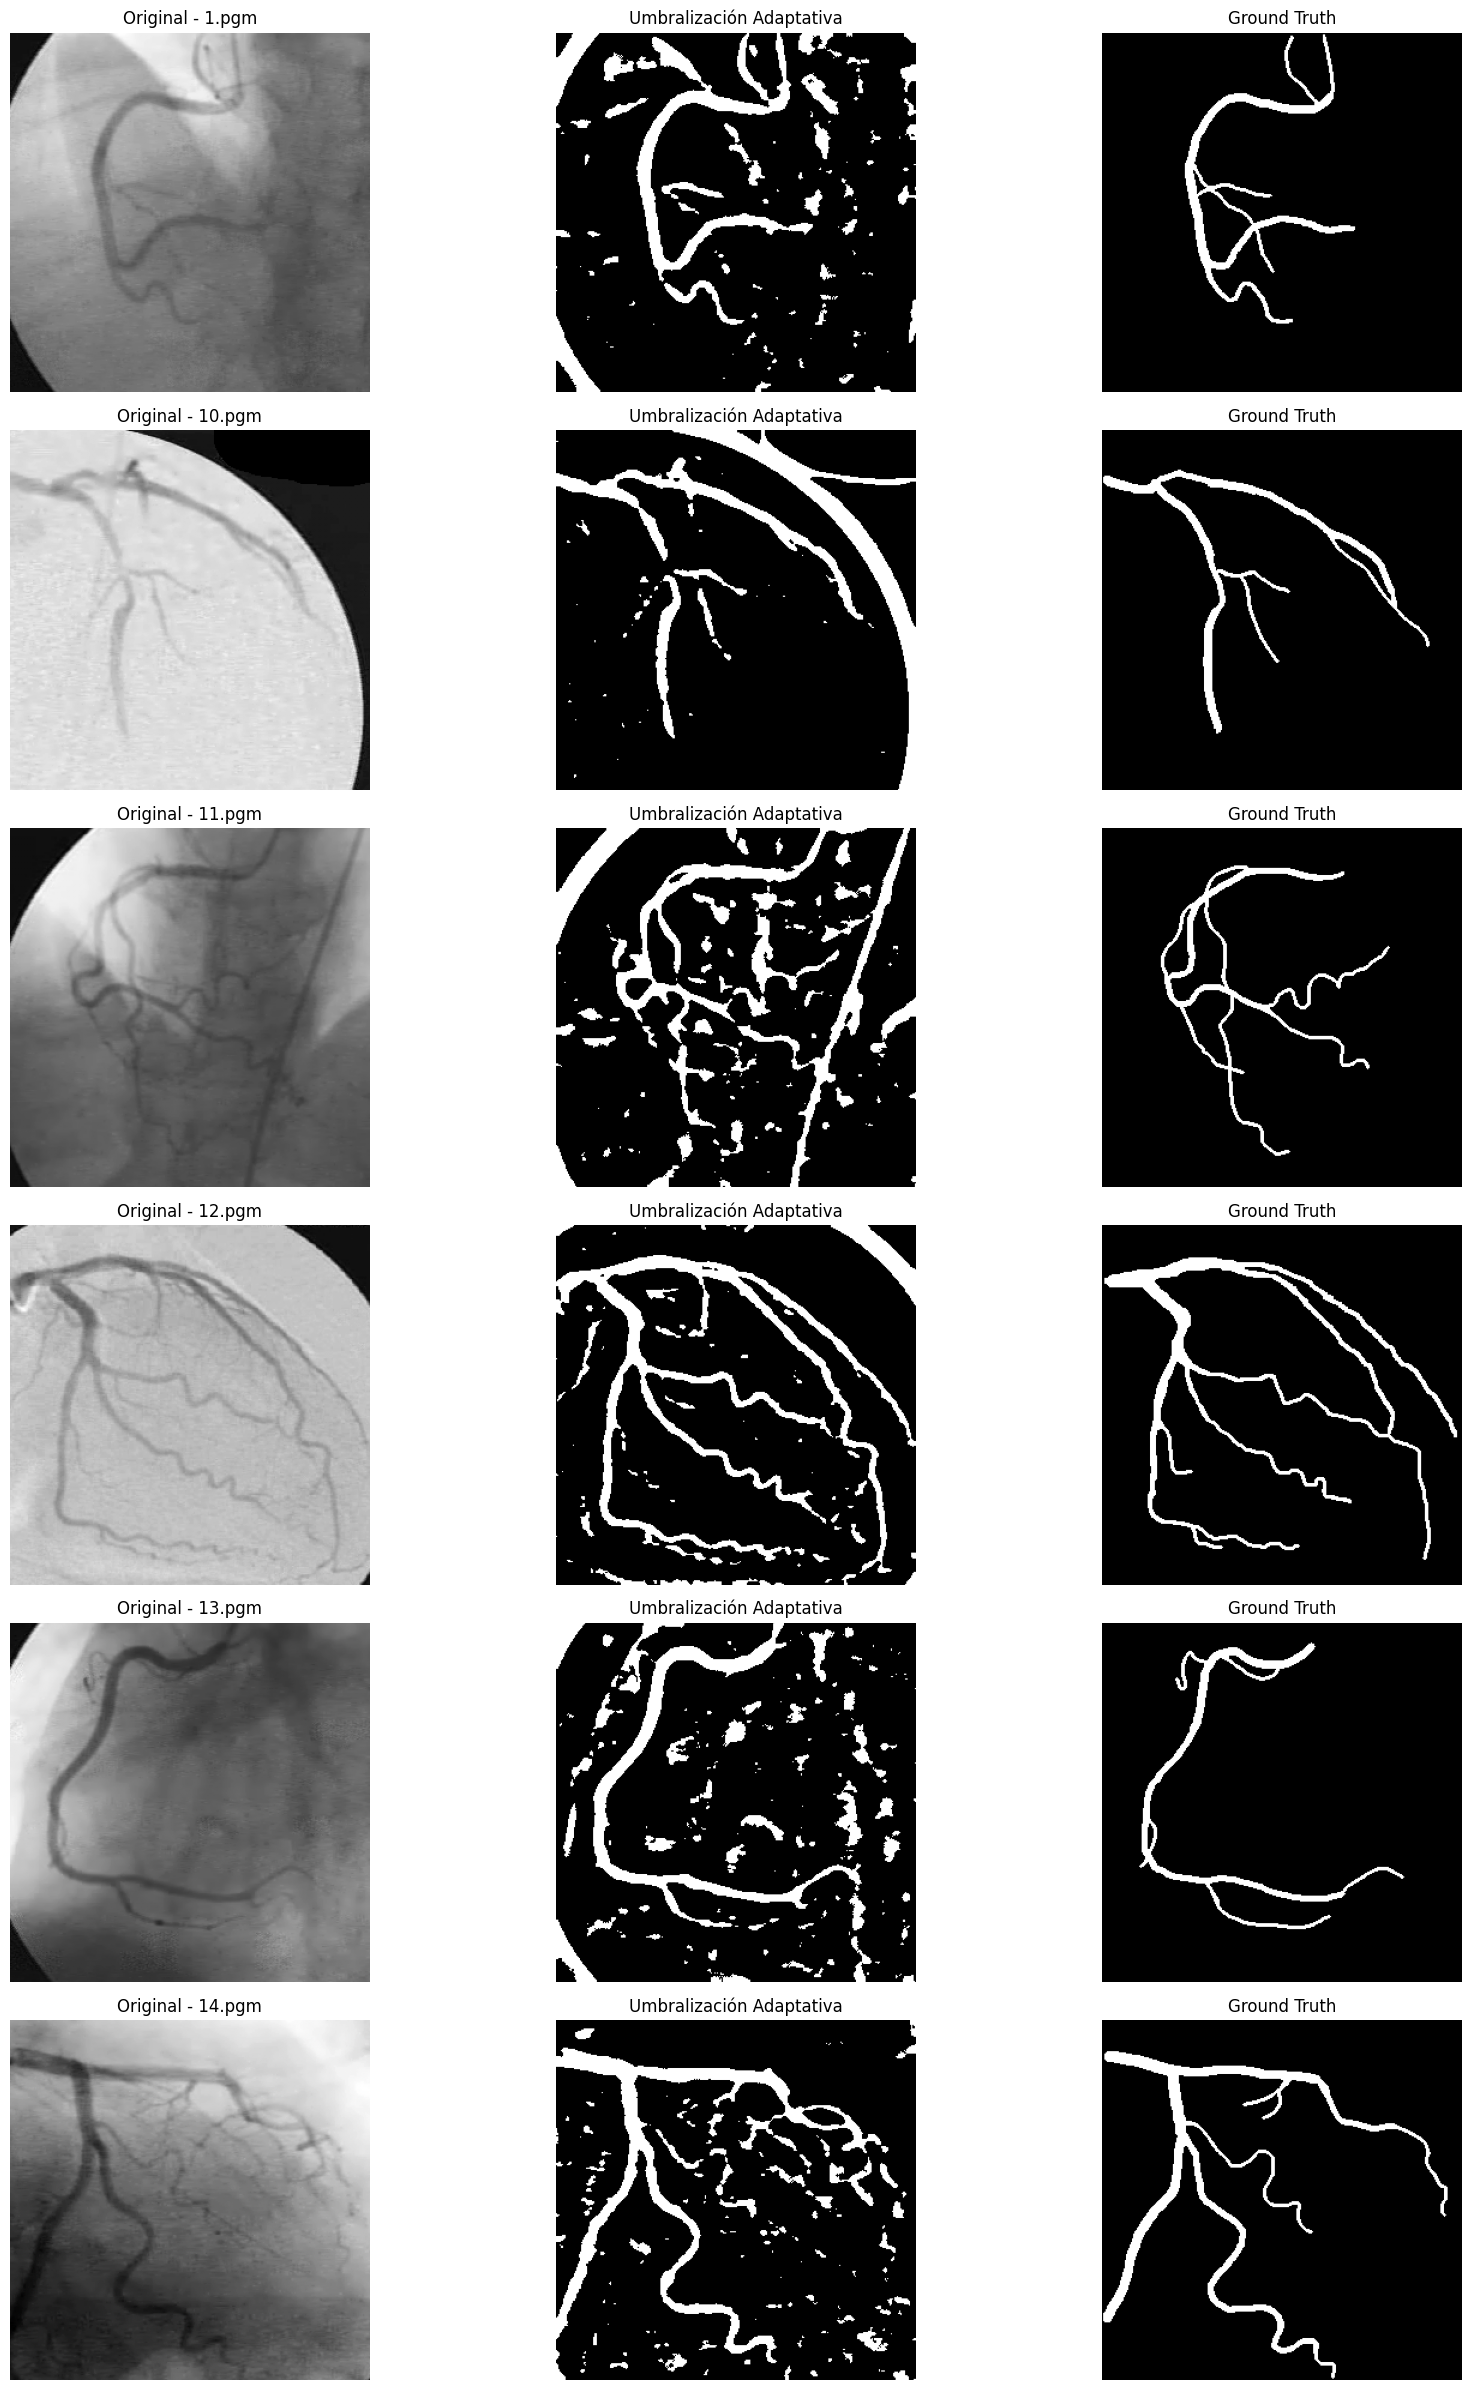

In [23]:
num_display = min(6, len(resultadosVisuales))

plt.figure(figsize=(18, 4 * num_display))

for i in range(num_display):
    filename, orig, binarized, gt = resultadosVisuales[i]
    
    plt.subplot(num_display, 3, 3*i + 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original - {filename}")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3*i + 2)
    plt.imshow(binarized, cmap='gray')
    plt.title("Umbralización Adaptativa")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3*i + 3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
plt.tight_layout()
plt.show()


In [24]:
df = pd.DataFrame(resultados)
print(df)

promedios = df.mean(numeric_only=True)
print("\nPromedios de métricas en umbralización adaptativa:")
print(promedios)

    Imagen  Accuracy    Recall  Specificity  Precision  F1 Score
0    1.pgm  0.907844  0.910870     0.907712   0.302079  0.453695
1   10.pgm  0.913033  0.847011     0.916062   0.316457  0.460765
2   11.pgm  0.861611  0.840481     0.862507   0.205847  0.330700
3   12.pgm  0.917656  0.924586     0.917059   0.489717  0.640295
4   13.pgm  0.890100  0.906983     0.889401   0.253573  0.396338
5   14.pgm  0.920722  0.873565     0.924360   0.471174  0.612165
6   15.pgm  0.936489  0.935477     0.936541   0.432082  0.591130
7   16.pgm  0.859944  0.932837     0.855681   0.274335  0.423982
8   17.pgm  0.900011  0.854355     0.902305   0.305228  0.449771
9   18.pgm  0.893289  0.817262     0.897427   0.302502  0.441563
10  19.pgm  0.962167  0.861664     0.967051   0.559639  0.678561
11   2.pgm  0.882733  0.917608     0.881006   0.276415  0.424850
12  20.pgm  0.894389  0.950360     0.890114   0.397785  0.560828
13   3.pgm  0.896522  0.932820     0.894937   0.279408  0.430014
14   4.pgm  0.910689  0.7

## Sauvola

In [30]:
import cv2
import numpy as np
import os

def manual_sauvola_threshold(img, window_size, k, R=128):

    if window_size % 2 == 0:
        raise ValueError("window_size debe ser impar")
    
    img_float = img.astype(np.float64)
    
    mean = cv2.boxFilter(img_float, ddepth=-1, ksize=(window_size, window_size), borderType=cv2.BORDER_REFLECT)
    
    sq_img = img_float ** 2
    mean_sq = cv2.boxFilter(sq_img, ddepth=-1, ksize=(window_size, window_size), borderType=cv2.BORDER_REFLECT)
    
    std = np.sqrt(mean_sq - mean**2)
    
    thresh = mean * (1 + k * ((std / R) - 1))
    
    binary = (img_float < thresh).astype(np.uint8) * 255
    return binary

windowsSize = 31
kSauvola = 0.2

resultadosSauvola = []
resultadosVisualesSauvola = []

for imagen in imagenes:
    img = cv2.imread(imagen, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print('Error al cargar la imagen ' + imagen)
        continue
    
    blurred = cv2.GaussianBlur(img, kernelSize, 0)
    
    sauvola_binary = manual_sauvola_threshold(blurred, windowsSize, kSauvola, R=128)
    
    filename = os.path.basename(imagen)
    gt_name = filename
    gt_path = os.path.join('datos', 'etiquetas', gt_name)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt is None:
        print('Error al cargar la imagen ' + gt_path)
        continue
    
    accuracy, recall, specificity, precision, f1_score = calcularMetricas(sauvola_binary, gt)
    
    resultadosVisualesSauvola.append((filename, img, sauvola_binary, gt))
    resultadosSauvola.append({
        'Imagen': filename,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score
    })


C:\Users\caste\AppData\Local\Temp\ipykernel_35828\3841761848.py:17: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(mean_sq - mean**2)


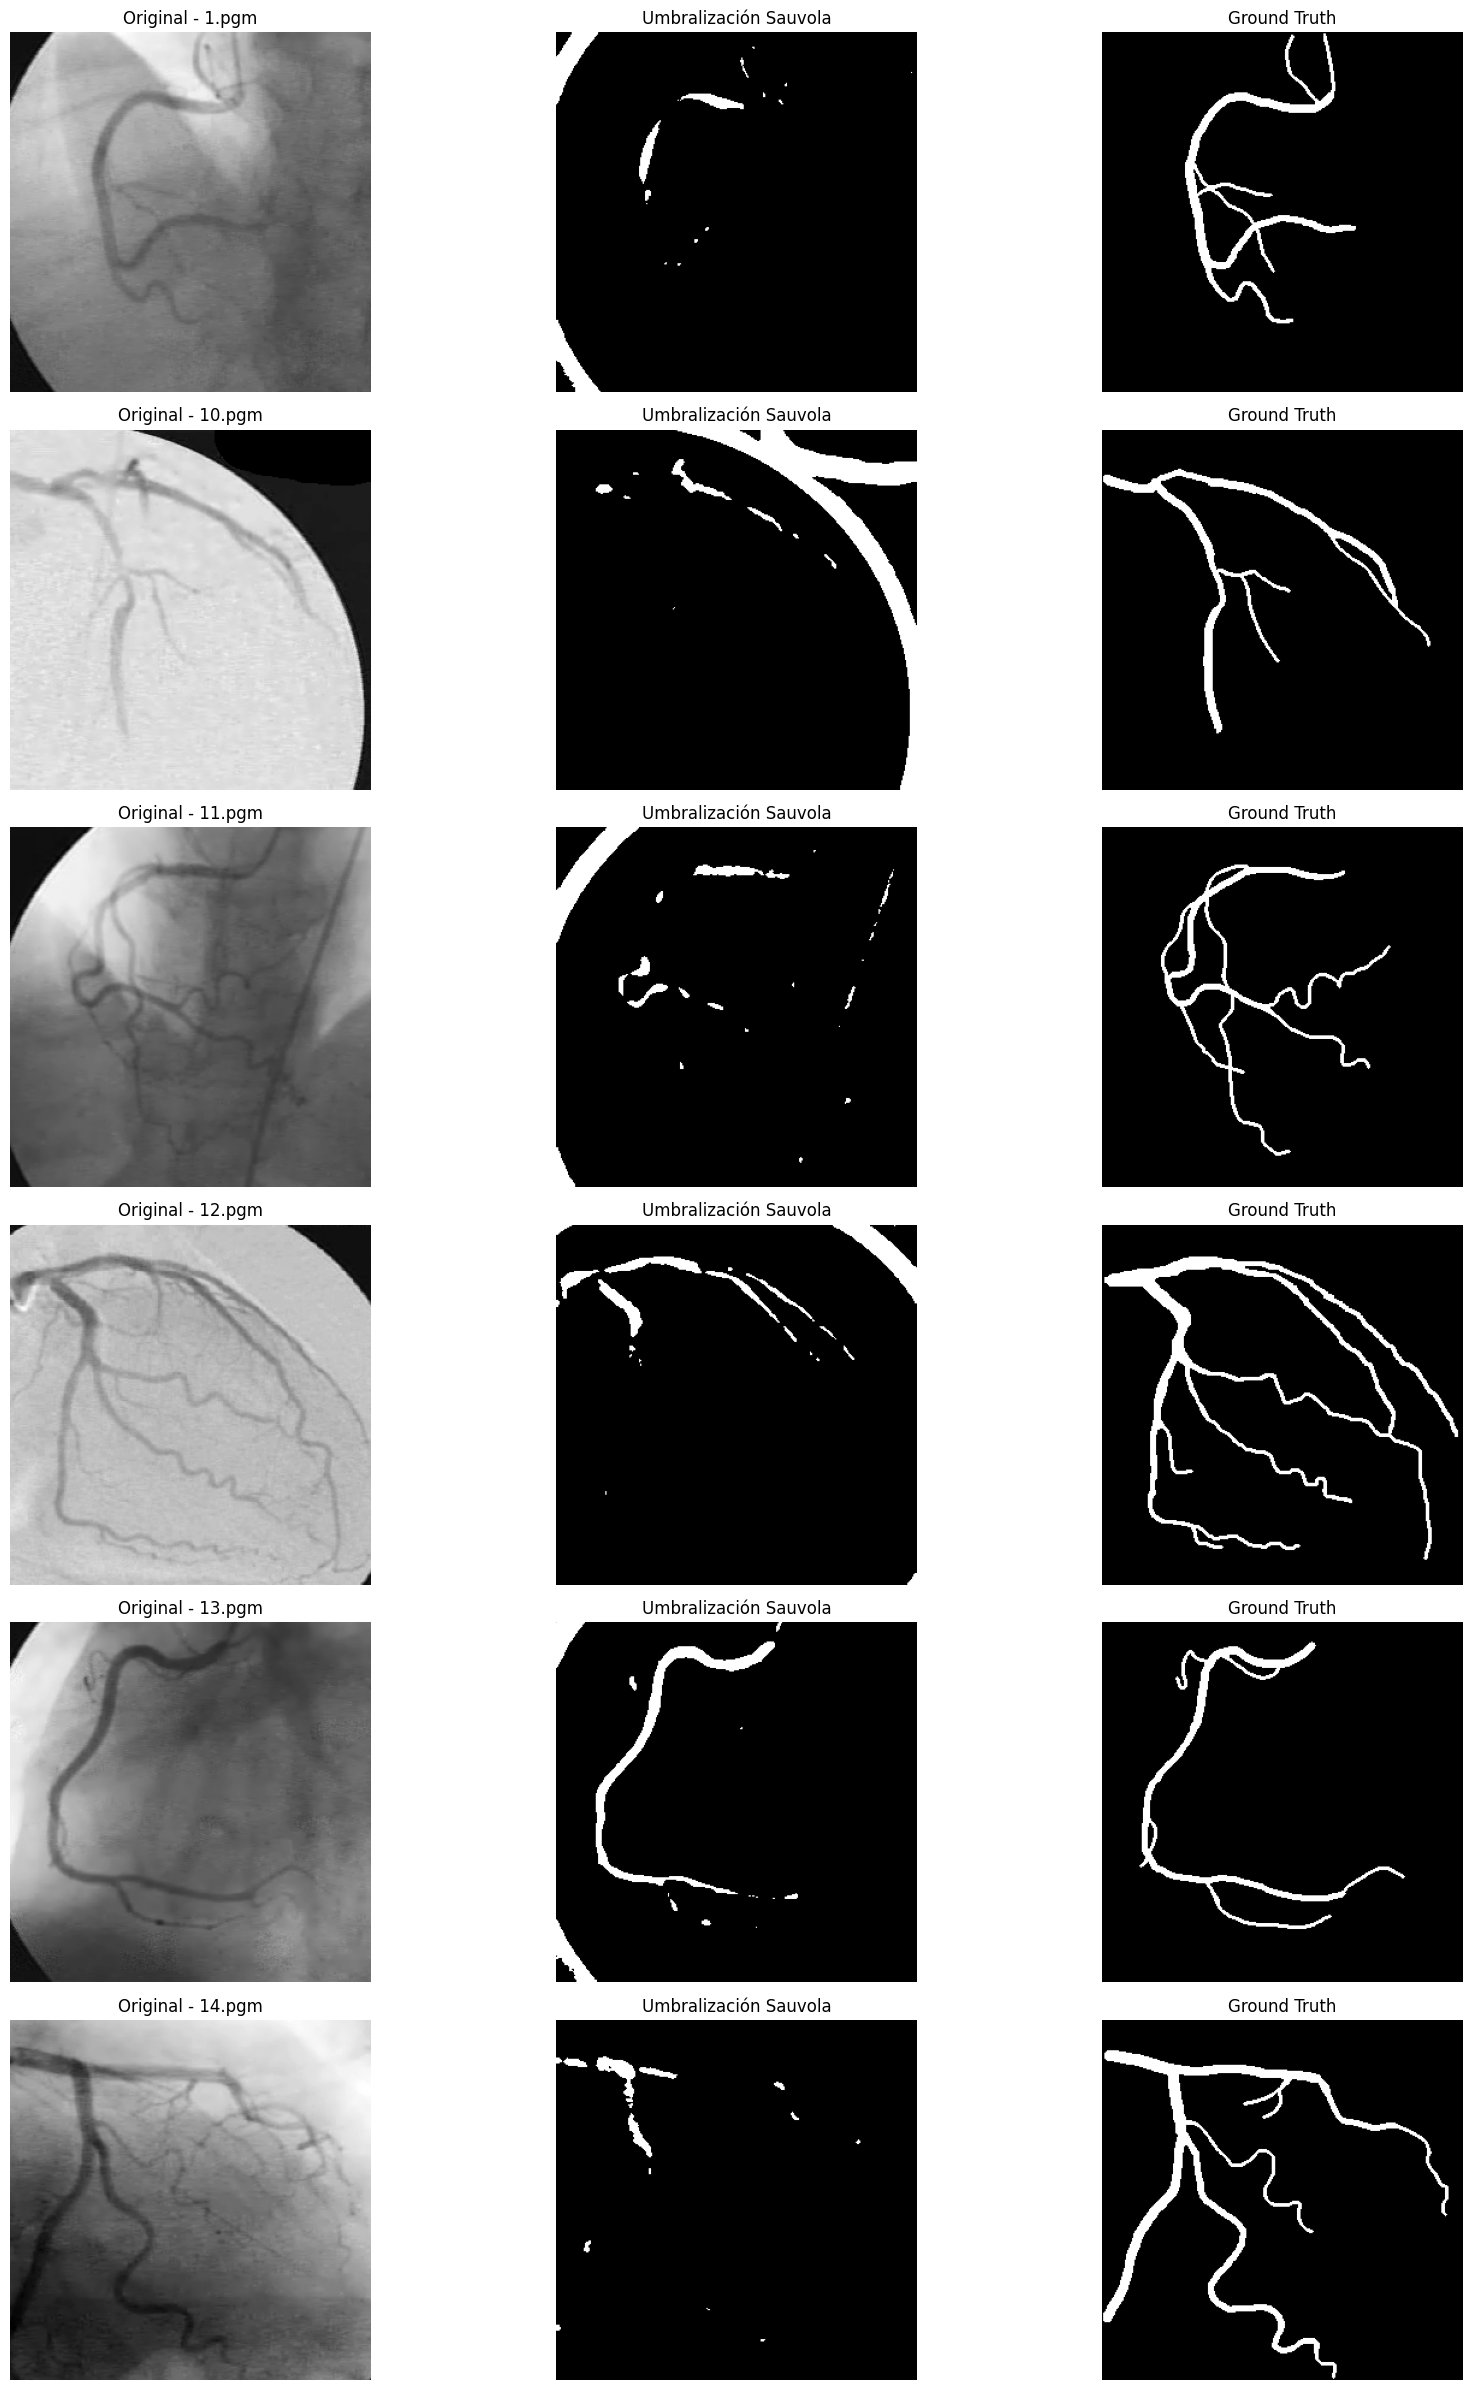

In [31]:
num_display = min(6, len(resultadosVisualesSauvola))
plt.figure(figsize=(18, 4 * num_display))

for i in range(num_display):
    filename, orig, binarized, gt = resultadosVisualesSauvola[i]
    
    # Imagen Original
    plt.subplot(num_display, 3, 3*i + 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original - {filename}")
    plt.axis('off')
    
    # Imagen Binarizada con Sauvola
    plt.subplot(num_display, 3, 3*i + 2)
    plt.imshow(binarized, cmap='gray')
    plt.title("Umbralización Sauvola")
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(num_display, 3, 3*i + 3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [32]:
df_sauvola = pd.DataFrame(resultadosSauvola)
print(df_sauvola)

promedios_sauvola = df_sauvola.mean(numeric_only=True)
print("\nPromedios de métricas con Sauvola:")
print(promedios_sauvola)

    Imagen  Accuracy    Recall  Specificity  Precision  F1 Score
0    1.pgm  0.947200  0.185401     0.980608   0.295407  0.227819
1   10.pgm  0.878622  0.116008     0.913610   0.058033  0.077365
2   11.pgm  0.941811  0.215242     0.972620   0.250000  0.231322
3   12.pgm  0.923344  0.252733     0.981078   0.534856  0.343265
4   13.pgm  0.967244  0.650559     0.980363   0.578490  0.612411
5   14.pgm  0.936789  0.145672     0.997822   0.837645  0.248183
6   15.pgm  0.958678  0.430383     0.985943   0.612436  0.505518
7   16.pgm  0.965711  0.532676     0.991038   0.776605  0.631918
8   17.pgm  0.917856  0.047154     0.961596   0.058100  0.052058
9   18.pgm  0.919944  0.087602     0.965251   0.120664  0.101509
10  19.pgm  0.954644  0.021338     1.000000   1.000000  0.041784
11   2.pgm  0.939522  0.220574     0.975138   0.305311  0.256116
12  20.pgm  0.947900  0.434858     0.987084   0.719990  0.542224
13   3.pgm  0.953111  0.231014     0.984646   0.396536  0.291946
14   4.pgm  0.958522  0.0

## Otsu + preprocesamiento de iluminación

In [33]:
import cv2
import numpy as np
import os

def manual_otsu_threshold(img):
    hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 256))
    total = img.size

    hist_norm = hist.astype(np.float64) / total

    cumulative_sum = np.cumsum(hist_norm)
    cumulative_mean = np.cumsum(np.arange(256) * hist_norm)
    global_mean = cumulative_mean[-1]

    epsilon = 1e-6
    numerator = (global_mean * cumulative_sum - cumulative_mean) ** 2
    denominator = cumulative_sum * (1 - cumulative_sum) + epsilon
    sigma_b_squared = numerator / denominator

    optimal_threshold = np.argmax(sigma_b_squared)
    
    binary = (img >= optimal_threshold).astype(np.uint8) * 255
    return optimal_threshold, binary

resultadosOtsu = []
resultadosVisualesOtsu = []

for imagen in imagenes:
    img = cv2.imread(imagen, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print('Error al cargar la imagen ' + imagen)
        continue
    
    equalized = cv2.equalizeHist(img)
    
    threshold_value, otsu_manual = manual_otsu_threshold(equalized)
    
    filename = os.path.basename(imagen)
    gtPath = os.path.join('datos', 'etiquetas', filename)
    gt = cv2.imread(gtPath, cv2.IMREAD_GRAYSCALE)
    if gt is None:
        print('Error al cargar la imagen ' + gtPath)
        continue
    
    accuracy, recall, specificity, precision, f1_score = calcularMetricas(otsu_manual, gt)
    resultadosVisualesOtsu.append((filename, img, otsu_manual, gt))
    resultadosOtsu.append({
        'Imagen': filename,
        'Threshold': threshold_value,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score
    })

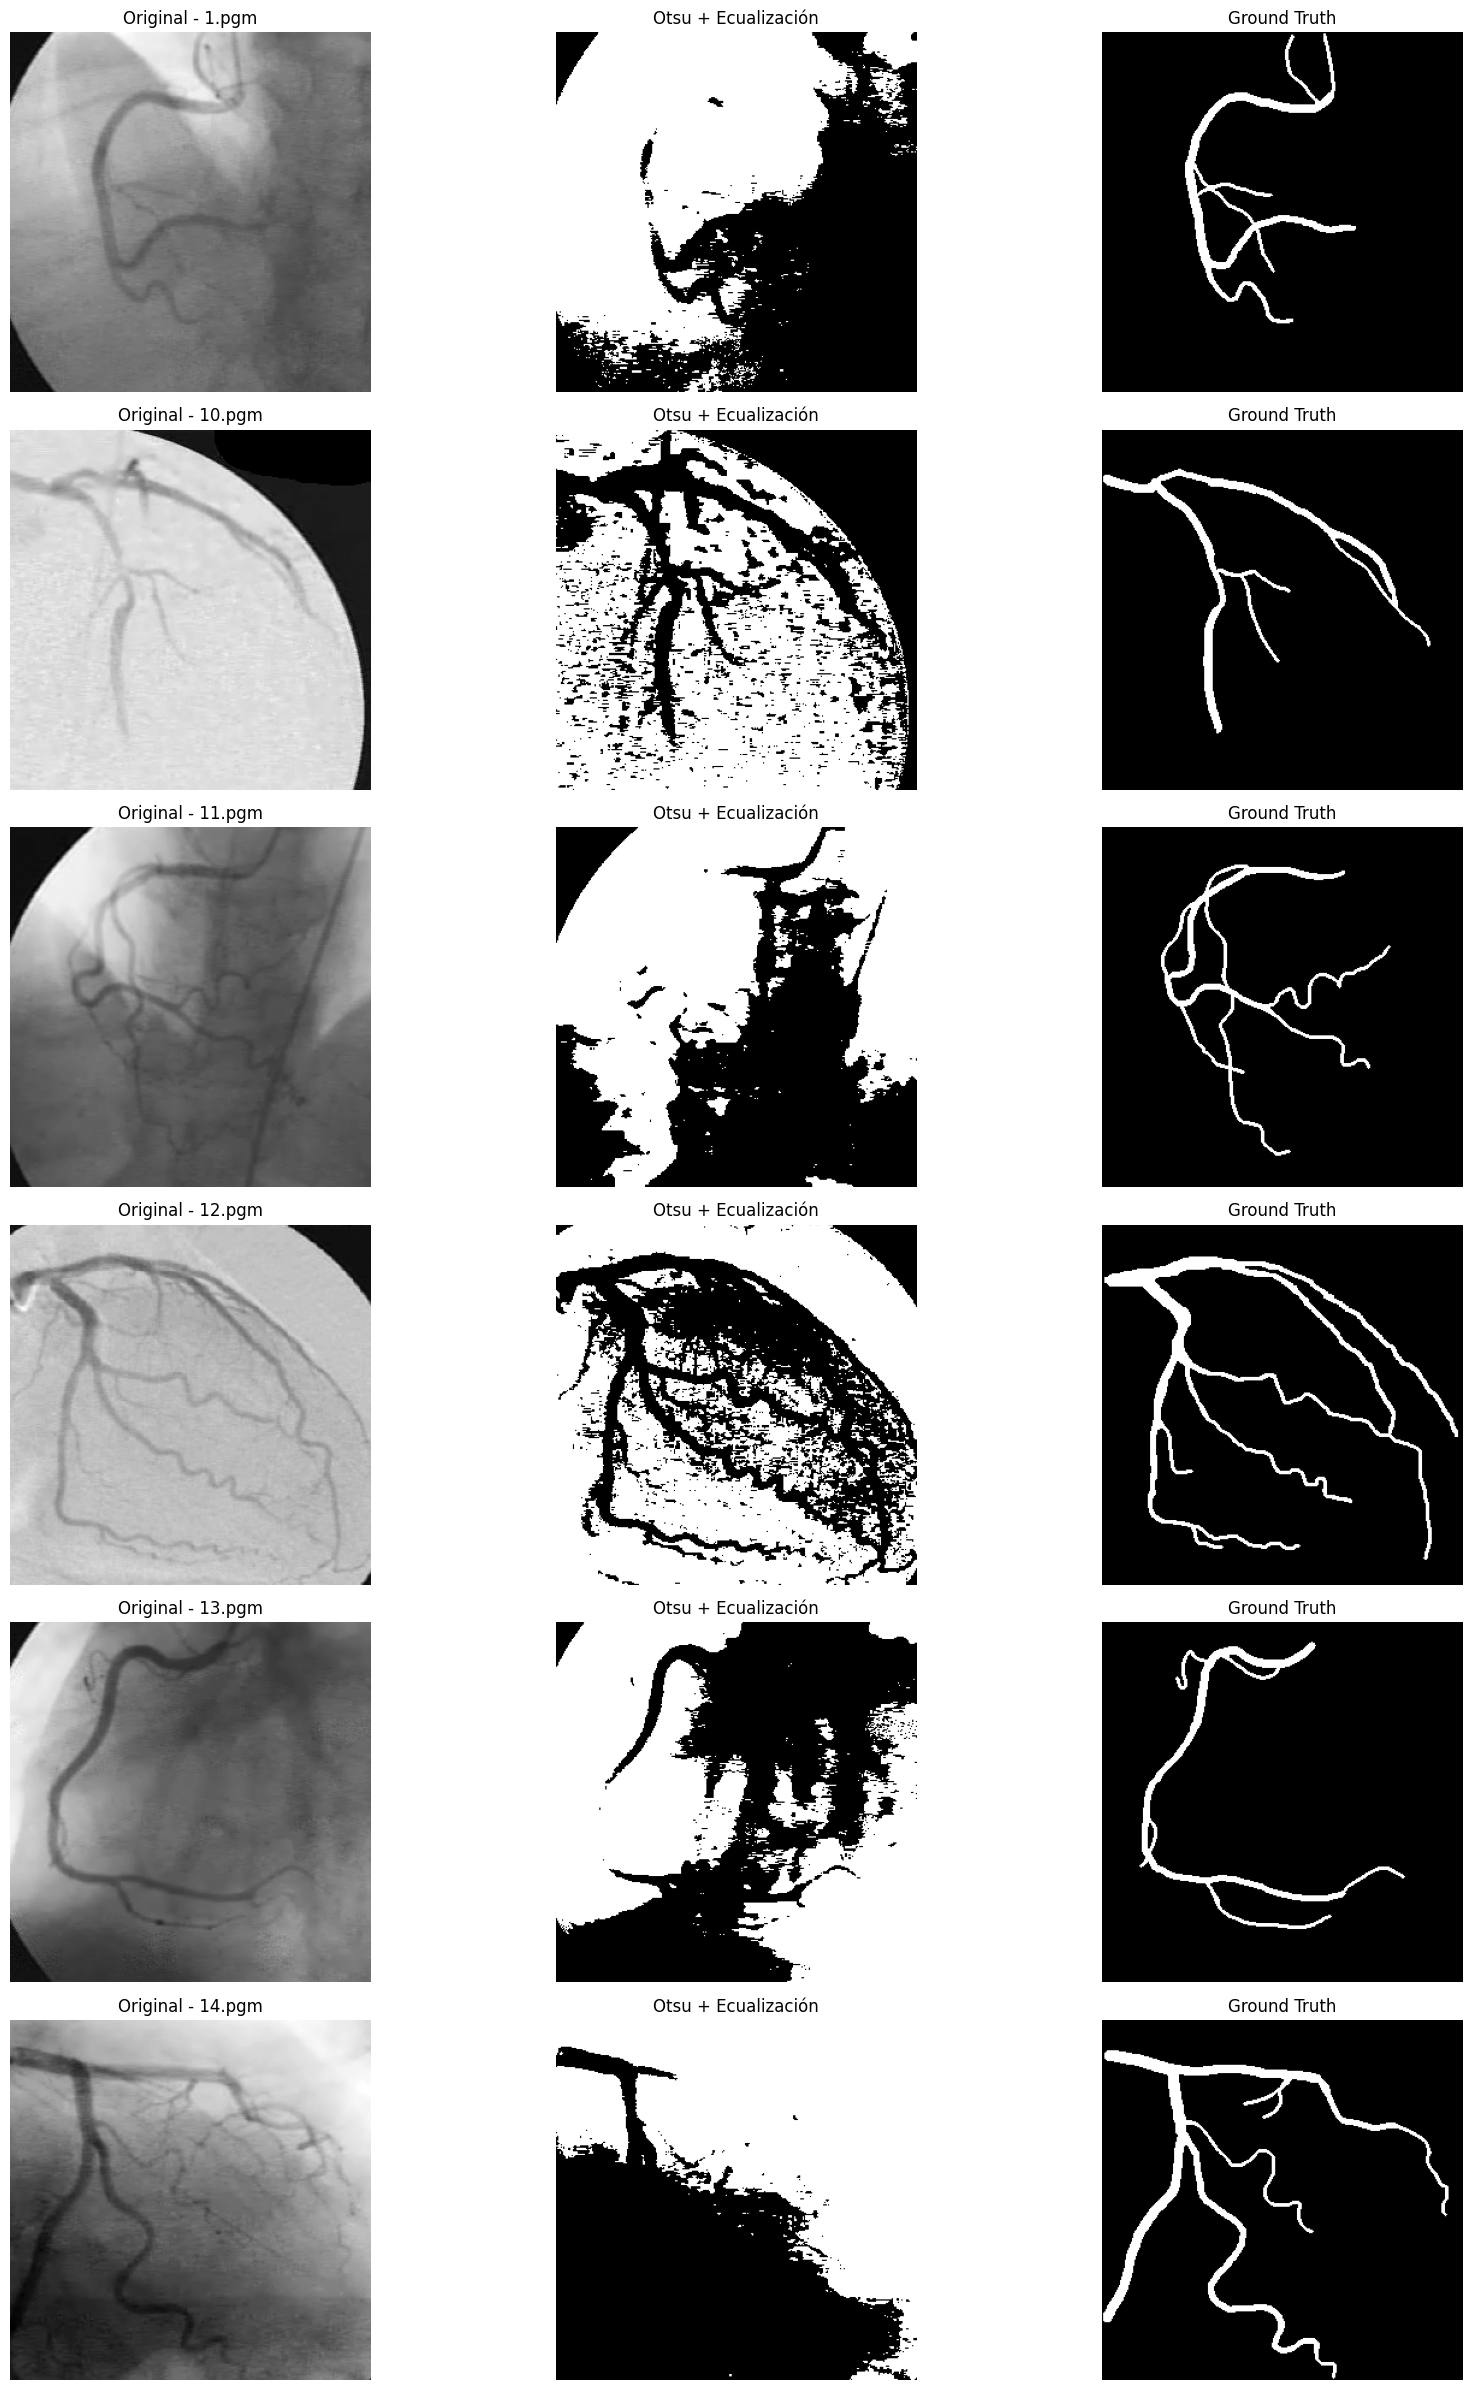

In [34]:
num_display = min(6, len(resultadosVisualesOtsu))
plt.figure(figsize=(18, 4 * num_display))

for i in range(num_display):
    filename, orig, binarized, gt = resultadosVisualesOtsu[i]
    
    plt.subplot(num_display, 3, 3*i + 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original - {filename}")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3*i + 2)
    plt.imshow(binarized, cmap='gray')
    plt.title("Otsu + Ecualización")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3*i + 3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [35]:
df_otsu = pd.DataFrame(resultadosOtsu)
print(df_otsu)

promedios_otsu = df_otsu.mean(numeric_only=True)
print("\nPromedios de métricas con Otsu + Ecualización:")
print(promedios_otsu)

    Imagen  Threshold  Accuracy    Recall  Specificity  Precision  F1 Score
0    1.pgm        127  0.477167  0.500661     0.476136   0.040225  0.074467
1   10.pgm        123  0.363733  0.003546     0.380258   0.000262  0.000489
2   11.pgm        125  0.467900  0.531276     0.465213   0.040421  0.075127
3   12.pgm        116  0.322033  0.013737     0.348575   0.001812  0.003202
4   13.pgm        125  0.445456  0.236034     0.454131   0.017597  0.032753
5   14.pgm        125  0.451200  0.289016     0.463712   0.039917  0.070146
6   15.pgm        128  0.353133  0.002264     0.371242   0.000186  0.000343
7   16.pgm        128  0.468611  0.335612     0.476390   0.036133  0.065242
8   17.pgm        129  0.461811  0.111034     0.479433   0.010601  0.019355
9   18.pgm        129  0.457311  0.068661     0.478466   0.007115  0.012894
10  19.pgm        106  0.266933  0.001678     0.279824   0.000113  0.000212
11   2.pgm        128  0.481167  0.339218     0.488199   0.031790  0.058132
12  20.pgm  

## Filtros de Gabor

In [1]:
import cv2
import numpy as np
import glob, os
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
import matplotlib.pyplot as plt

def build_gabor_kernel_manual(ksize, sigma, theta, lambd, gamma, psi):
    half = ksize // 2
    y, x = np.meshgrid(np.arange(-half, half+1), np.arange(-half, half+1))
    x_prime = x * np.cos(theta) + y * np.sin(theta)
    y_prime = -x * np.sin(theta) + y * np.cos(theta)
    kernel = np.exp(-(x_prime**2 + (gamma**2)*(y_prime**2)) / (2 * sigma**2)) \
             * np.cos(2 * np.pi * x_prime / lambd + psi)
    return kernel

def build_gabor_kernels_manual(ksize=31, sigma=4.0, lambd=10.0, gamma=0.5, psi=0,
                               orientations=[0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 
                                             5*np.pi/8, 3*np.pi/4, 7*np.pi/8]):
    kernels = []
    for theta in orientations:
        kernel = build_gabor_kernel_manual(ksize, sigma, theta, lambd, gamma, psi)
        kernel = kernel - kernel.mean()
        kernels.append(kernel)
    
    kernels = np.array(kernels) 
    kernels = kernels.transpose(1, 2, 0)
    kernels = np.expand_dims(kernels, axis=2)
    return kernels


gabor_kernels_manual = build_gabor_kernels_manual(ksize=31, sigma=4.0, lambd=10.0, gamma=0.5)
num_gabor_filters = gabor_kernels_manual.shape[-1]
print("Forma de los kernels Gabor:", gabor_kernels_manual.shape)


directorioImagenes = 'datos/imagenes'
directorioEtiquetas = 'datos/etiquetas'
imagenes_paths = sorted(glob.glob(os.path.join(directorioImagenes, '*.pgm')))

def cargar_preprocesar(imagen_path):
    img = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = img.astype(np.float32) / 255.0
    return img

def cargar_gt(imagen_path):
    filename = os.path.basename(imagen_path)
    gt_path = os.path.join(directorioEtiquetas, filename)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt is None:
        return None
    gt = gt.astype(np.float32) / 255.0
    return gt

images = []
gts = []
for path in imagenes_paths:
    img = cargar_preprocesar(path)
    gt = cargar_gt(path)
    if img is not None and gt is not None:
        images.append(img)
        gts.append(gt)
        
images = np.array(images)[..., np.newaxis]
gts = np.array(gts)[..., np.newaxis]


input_img = layers.Input(shape=images.shape[1:])


gabor_layer = layers.Conv2D(
    filters=num_gabor_filters,
    kernel_size=(31, 31),
    padding='same',
    kernel_initializer=initializers.Constant(gabor_kernels_manual),
    trainable=True 
)(input_img)

x = layers.Activation('relu')(gabor_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

model = models.Model(inputs=input_img, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


history = model.fit(images, gts, batch_size=2, epochs=150, validation_split=0.2)
preds = model.predict(images)

Forma de los kernels Gabor: (31, 31, 1, 8)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 8)    │         7,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 300, 300, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 300, 300, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 300, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 300, 300, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,553 (52.94 KB)

 Non-trainable params: 16 (64.00 B)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.8632 - loss: 0.5749 - val_accuracy: 0.9542 - val_loss: 0.2777
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9497 - loss: 0.3386 - val_accuracy: 0.9542 - val_loss: 0.7109
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9516 - loss: 0.2220 - val_accuracy: 0.9542 - val_loss: 0.8727
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9492 - loss: 0.2575 - val_accuracy: 0.9542 - val_loss: 0.8319
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9495 - loss: 0.2265 - val_accuracy: 0.9542 - val_loss: 0.6654
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9520 - loss: 0.2318 - val_accuracy: 0.9542 - val_loss: 0.4350
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9471 - loss: 0.2382 - val_accuracy: 0.9542 - val_loss: 0.3111
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9520 - loss: 0.2118 - val_accuracy: 0.9542 - v

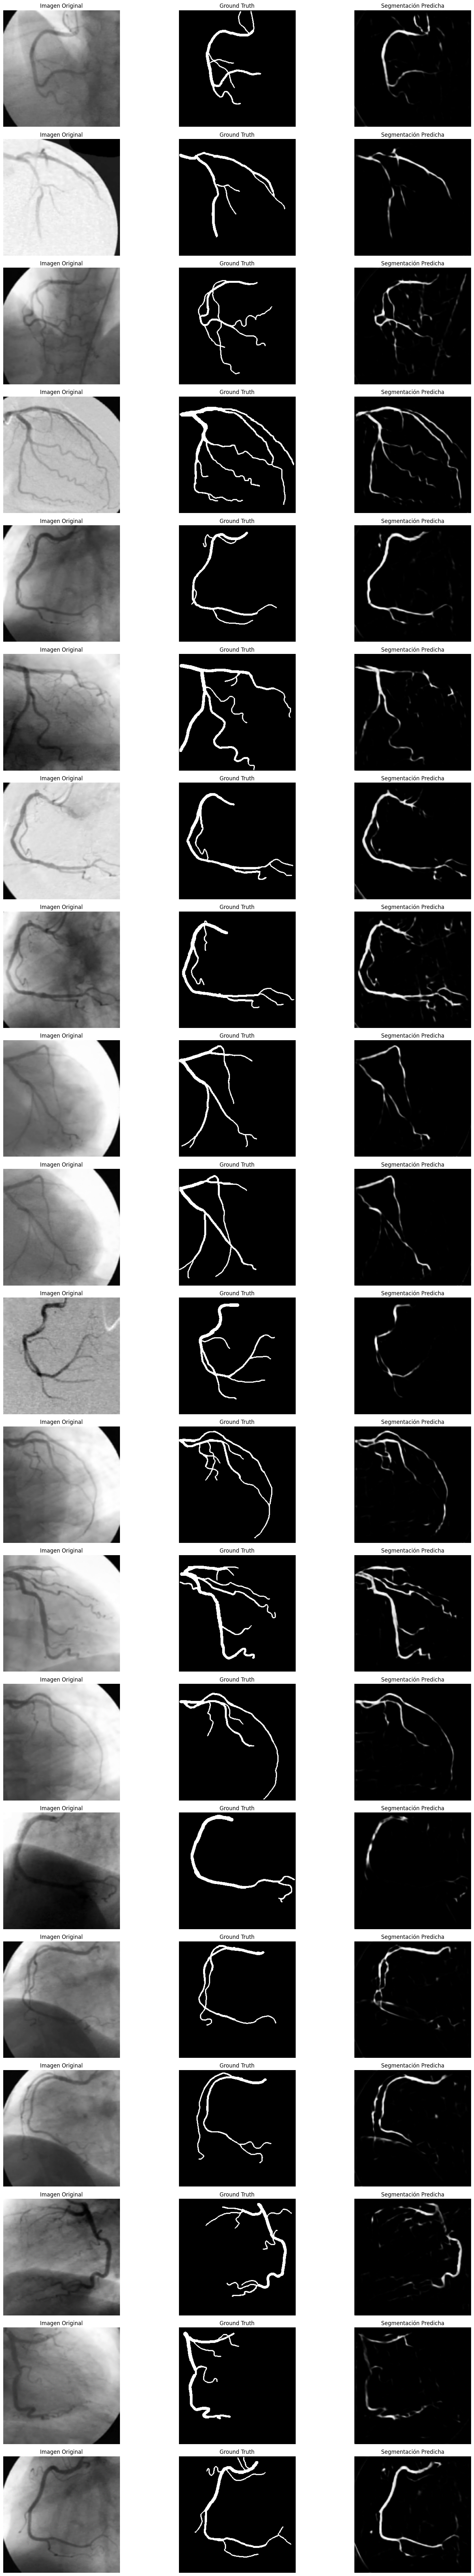

In [2]:
num_display = images.shape[0]
plt.figure(figsize=(18, 4 * num_display))
for i in range(num_display):
    plt.subplot(num_display, 3, 3 * i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Imagen Original")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3 * i + 2)
    plt.imshow(gts[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(num_display, 3, 3 * i + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Segmentación Predicha")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def calcularMetricas(pred, gt, threshold=0.5):
    pred_bin = (pred >= threshold).astype(np.uint8) * 255
    gt_bin = (gt >= threshold).astype(np.uint8) * 255

    TP = np.sum((pred_bin == 255) & (gt_bin == 255))
    TN = np.sum((pred_bin == 0)   & (gt_bin == 0))
    FP = np.sum((pred_bin == 255) & (gt_bin == 0))
    FN = np.sum((pred_bin == 0)   & (gt_bin == 255))
    
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    union = TP + FP + FN
    iou = TP / union if union else 0

    dice = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) else 0

    return accuracy, recall, specificity, precision, f1_score, iou, dice

metricas = []
for i in range(len(images)):
    met = calcularMetricas(preds[i], gts[i])
    metricas.append(met)

metricas = np.array(metricas)
average_metrics = np.mean(metricas, axis=0)
metrics_names = ["Accuracy", "Recall", "Specificity", "Precision", "F1 Score", "IoU", "Dice"]

print("Métricas promedio:")
for name, value in zip(metrics_names, average_metrics):
    print(f"{name}: {value:.4f}")

Métricas promedio:
Accuracy: 0.9653
Recall: 0.3398
Specificity: 0.9978
Precision: 0.8903
F1 Score: 0.4723
IoU: 0.3229
Dice: 0.4723
